In [1]:
import numpy as np
from collections import defaultdict, namedtuple
from text_generator import TextGenerator
import gzip
import cPickle as pickle
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sb
% matplotlib inline
import matplotlib.pyplot as plt
import operator

In [2]:
sb.set_context('poster', rc={'figure.figsize':(12, 12)})

In [57]:
class BiGramModel(object):


    def __init__(self, transcripts, target_period=3, max_vocab_size=None, min_count=50, verbose=True):

        # Initiate some necessary variables
        self._transcripts = transcripts
        self._vocab = defaultdict(dict)
        self._features = list()
        self._targets = list()
        self.max_vocab_size = max_vocab_size
        self.min_count = min_count
        self.stop_words = "a an the for which our by as we that on in with or is are also and of to you these " \
                          "from at last where will i now how have be per during about these this - was year " \
                          "were call it has us than so not like very but million quarter over new first " \
                          "third their would those there . ? ! , & % $ [ ] ( ) ; and/or your 's 're 'd 've".split()

        # Set the target period
        assert target_period in (3, 30, 60, 90), 'Invalid target period: {} days'.format(target_period)
        self.target_period = target_period

        # Build the vocabulary
        self.build_vocab(verbose)
        self.finalize_vocab()
        self.TFIDF()


    def build_vocab(self, verbose):

        for key, transcript in self._transcripts.iteritems():

            abnormal_return = self.get_return(transcript)

            if abnormal_return < -0.05:
                self._targets.append(0)
            elif -0.05 <= abnormal_return < 0.05:
                self._targets.append(1)
            elif abnormal_return >= 0.05:
                self._targets.append(2)
            else:
                continue

            # Tracks how often words appear in the transcript
            tracker = defaultdict(int)

            for paragraph in TextGenerator(transcript):

                # Remembers last word for bigrams
                last_word = None

                for word in paragraph:

                    # Ignore stop words
                    if word in self.stop_words:
                        continue

                    # Ignore numbers
                    try:
                        float(word)
                        continue
                    except ValueError:
                        if last_word:
                            tracker[' '.join([last_word, word])] += 1
                        tracker[word] += 1
                        last_word = word

            for word in tracker:
                self._vocab[word][key] = tracker[word]

            if verbose:
                if key % 250 == 0:
                    print("PROGRESS: at transcript #{}, keeping {} word types".format(key, len(self._vocab)))

                if key % 1000 == 0:
                    self.trim_vocab(min_reduce=2)


    def TFIDF(self):

        print("Computing TF-IDF...")
        # Compute inverse document frequency
        N = len(self._transcripts)
        idf = defaultdict(float)
        for word in self._vocab:
            freq = len(self._vocab[word])
            idf[word] = np.log(float(N) / freq)

        # Reaugment dictionary so transcripts are first-order keys and words are second-order keys
        # Also set self._vocab to now just be the actual vocabulary
        vocab = self._vocab.keys()
        self._features = {doc: {word: self._vocab[word][doc] for word in self._vocab if doc in self._vocab[word]}
                          for doc in self._transcripts}
        self._vocab = vocab

        for doc in self._features:
            max_freq = float(max(self._features[doc].values()))
            self._features[doc] = {word: ((count / max_freq) * 0.5 + 0.5) * idf[word] for word, count in
                                 self._features[doc].iteritems()}


    def trim_vocab(self, min_reduce):

        """ Trims all words that appear less than min_reduce times """

        start = len(self._vocab)
        for word in self._vocab.keys():
            if sum(self._vocab[word].values()) < min_reduce:
                del self._vocab[word]
        print("trimmed {} word types, {} word types remaining".format(start - len(self._vocab), len(self._vocab)))


    def finalize_vocab(self):

        while self.max_vocab_size and len(self._vocab) > self.max_vocab_size:
            self.trim_vocab(min_reduce=self.min_count)
            self.min_count += np.sqrt(np.sqrt(len(self.vocab)))

        print("collected {} word types".format(len(self._vocab)))


    def get_return(self, transcript):

        if self.target_period == 3:
            return transcript.return_3days
        elif self.target_period == 30:
            return transcript.return_30days
        elif self.target_period == 60:
            return transcript.return_60days
        else:
            return transcript.return_90days


    @property
    def transcripts(self):
        return self._transcripts

    @property
    def vocab(self):
        return self._vocab

    @property
    def inputs(self):
        return self._features

    @property
    def targets(self):
        return self._targets

In [4]:
Transcript = namedtuple('Transcript', ['company',       
                                       'ticker',        
                                       'date',          
                                       'return_3days',  
                                       'return_30days', 
                                       'return_60days', 
                                       'return_90days', 
                                       'prepared',      
                                       'QandA'])

In [5]:
def load_transcripts():                                            
    with gzip.open('../data/transcripts.p.gz') as f:         
        return pickle.load(f)                                      

In [10]:
def init_model(transcripts):                                                                
    return SkipGramModel(transcripts, target_period=3, max_vocab_size=None, min_count=50)

In [7]:
transcripts = load_transcripts()

In [13]:
m = init_model(transcripts)

PROGRESS: at transcript #250, keeping 274190 word types
PROGRESS: at transcript #500, keeping 477620 word types
PROGRESS: at transcript #750, keeping 644994 word types
PROGRESS: at transcript #1000, keeping 804029 word types
trimmed 576414 word types, 227615 word types remaining
PROGRESS: at transcript #1250, keeping 410529 word types
PROGRESS: at transcript #1500, keeping 575474 word types
PROGRESS: at transcript #1750, keeping 734401 word types
PROGRESS: at transcript #2000, keeping 885158 word types
trimmed 541545 word types, 343613 word types remaining
PROGRESS: at transcript #2250, keeping 509946 word types
PROGRESS: at transcript #2500, keeping 666781 word types
PROGRESS: at transcript #2750, keeping 823514 word types
PROGRESS: at transcript #3000, keeping 960085 word types
trimmed 523886 word types, 436199 word types remaining
PROGRESS: at transcript #3250, keeping 592451 word types
PROGRESS: at transcript #3500, keeping 733000 word types
PROGRESS: at transcript #3750, keeping 8

In [14]:
x = np.asarray([np.asarray([doc[word] if word in doc else 0 for word in m.vocab]) for doc in m.inputs.values()])
y = np.asarray(m.targets)

In [16]:
print len(x), len(y)

57015 57015


In [33]:
while np.argmax(y) not in (0, 1, 2, 3, 4):
    y = np.delete(y, np.argmax(y), axis=0)
    x = np.delete(x, np.argmax(y), axis=0)

In [34]:
sss = StratifiedShuffleSplit(y, n_iter=1, test_size=0.25, random_state=0)
for train_index, test_index in sss:
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [35]:
rf_clf = RandomForestClassifier(100)

In [36]:
rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)

In [37]:
confusion_matrix(y_test, y_pred)

array([[ 132,    7, 2494,    7,   80],
       [  55,    3, 1690,    4,   45],
       [ 182,   14, 5018,   10,  106],
       [  52,    8, 1670,    4,   36],
       [ 105,    7, 2437,    7,   81]])

In [38]:
accuracy_score(y_test, y_pred)

0.36747579626771432

In [41]:
importances = zip(m.vocab, np.absolute(rf_clf.feature_importances_))
importances = sorted(importances, key=operator.itemgetter(1), reverse=True)

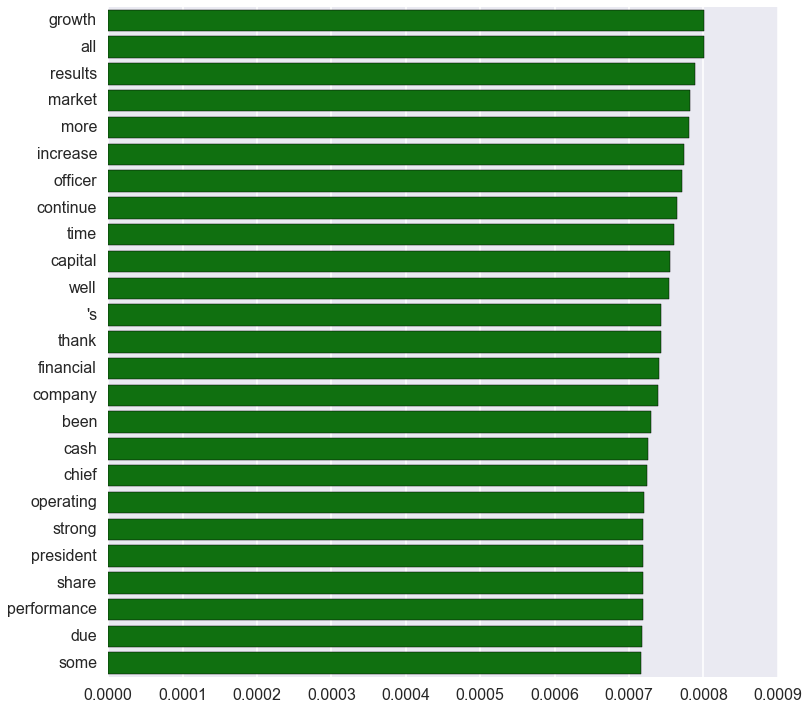

In [42]:
sb.barplot(y=zip(*importances)[0][:25], x=zip(*importances)[1][:25], color='g', orient='h');

In [58]:
lr_clf = LogisticRegression()

In [52]:
lr_clf.fit(x_train, y_train)
y_pred = lr_clf.predict(x_test)

/Users/trevorlindsay/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


In [53]:
confusion_matrix(y_test, y_pred)

array([[ 576,  339,  934,  311,  560],
       [ 362,  235,  612,  240,  348],
       [1015,  707, 1980,  645,  983],
       [ 315,  229,  653,  246,  327],
       [ 531,  337,  911,  317,  541]])

In [54]:
accuracy_score(y_test, y_pred)

0.25101725831345589

In [55]:
importances = zip(m.vocab, np.sum(np.absolute(lr_clf.coef_), axis=0))
importances = sorted(importances, key=operator.itemgetter(1), reverse=True)

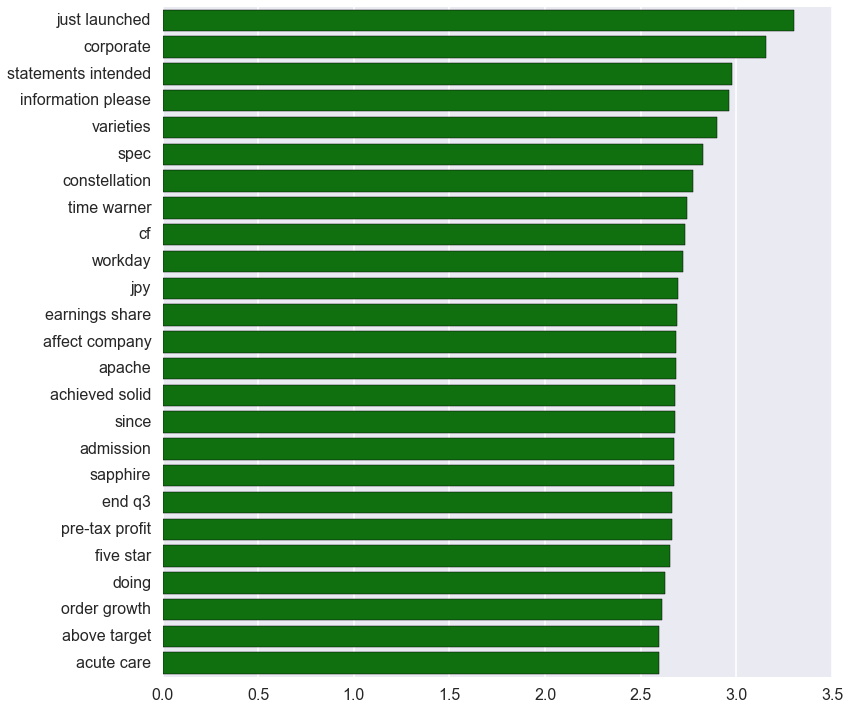

In [56]:
sb.barplot(y=zip(*importances)[0][:25], x=zip(*importances)[1][:25], color='g', orient='h');